In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import skimage

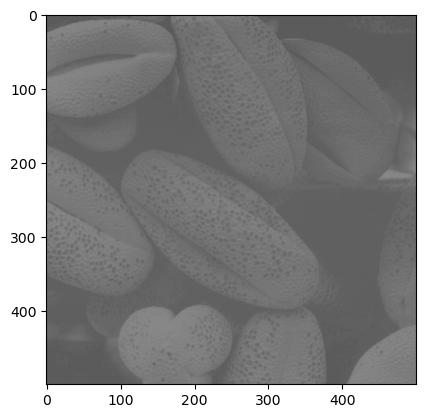

(500, 500)


In [9]:
########## EXAMPLE IMAGE ##########

imgArr = cv.imread("./Images/LowContrast.tif", cv.IMREAD_GRAYSCALE)
#imgArr = skimage.data.moon()

plt.imshow(imgArr, cmap='gray', vmin = 0, vmax=255)
plt.show()
print(imgArr.shape)

In [66]:
########## HELPER FUNCTIONS ##########

def zero_pad(arr, padWidth = 1):
  '''
  Zero pads an array by padWidth on all sides
  '''
  numRow, numCol = arr.shape
  paddedShape = (numRow + 2*padWidth, numCol + 2*padWidth)
  padArr = np.zeros(paddedShape)
  # Copy the original array into the center of the padded array
  padArr[padWidth:numRow+padWidth, padWidth:numCol+padWidth] = arr
  return padArr

def replicate_pad(arr, padWidth = 1):
  numRow, numCol = arr.shape
  # Start with a zero pad
  padArr = zero_pad(arr, padWidth)
  # Replicate pad along rows
  for i in range(padWidth):
    padArr[i, padWidth:numCol+padWidth] = arr[0, :]
    padArr[i+numRow+padWidth,padWidth:numCol+padWidth] = arr[-1, :]
  # Replicate pad along columns
  for j in range(padWidth):
    padArr[:,j] = padArr[:,padWidth]
    padArr[:,j+numCol+padWidth] = padArr[:,numCol+padWidth-1]
  return padArr


def mirror_pad(arr, padWidth = 1):
  numRow, numCol = arr.shape
  # Start with a zero pad
  padArr = zero_pad(arr, padWidth)
  # Mirror pad along rows
  for i in range(padWidth):
    padArr[i,padWidth:numCol+padWidth] = arr[padWidth-i,:]
    padArr[i+numRow+padWidth,padWidth:numCol+padWidth] = arr[numRow-i-2,:]
  # Mirror pad along columns
  for j in range(padWidth):
    padArr[:,j] = padArr[:,2*padWidth-j]
    padArr[:,j+numCol+padWidth] = padArr[:,numCol+padWidth-j-2]
  return padArr

def mirror_pad_axis(arr, pad=(1,1,1,1)):
  '''
  Mirror pads an array by a specific amount along the top, bottom, left, and right

  Args:
    arr (np.ndarray): The input two-dimensional array
    pad (tuple): Describes the amount of padding on each side as (top, bottom, left, right)
  
  Returns:
    np.ndarray: The mirror padded array
  '''
  # Start with an asymmetrical zero pad
  numRow, numCol = arr.shape
  padArr = np.zeros((numRow+pad[0]+pad[1],numCol+pad[2]+pad[3]))
  padArr[pad[0]:numRow+pad[0],pad[2]:numCol+pad[2]] = arr
  # Pad top
  for i in range(pad[0]):
    padArr[i,pad[2]:numCol+pad[2]] = arr[pad[0]-i,:]
  # Pad bottom
  for i in range(pad[1]):
    padArr[i+numRow+pad[0],pad[2]:numCol+pad[2]] = arr[numRow-i-2,:]
  # Pad left
  for j in range(pad[2]):
    padArr[:,j] = padArr[:,2*pad[2]-j]
  # Pad right
  for j in range(pad[3]):
    padArr[:,j+numCol+pad[2]] = padArr[:,numCol+pad[2]-j-2]
  return padArr

def strip_padding(arr, padWidth=1):
  return arr[padWidth:-padWidth, padWidth:-padWidth]

def strip_padding_axis(arr, pad):
  pass

def histogram_arr(arr, numLevels=256):
    histogram = np.zeros(numLevels)
    #for val in np.nditer(arr): #Consider not using nditer for performance
        #histogram[val] += 1
    for row in arr:
      for val in row:
        print(type(val))
        histogram[val] += 1
    return histogram

def histogram_dict(arr):
  histogramDict = {}
  for row in arr:
    for pixel in row:
      if pixel in histogramDict:
        histogramDict[pixel] += 1
      else:
        histogramDict[pixel] = 1
  return histogramDict

def histogram_binned(arr, bins):
  pass

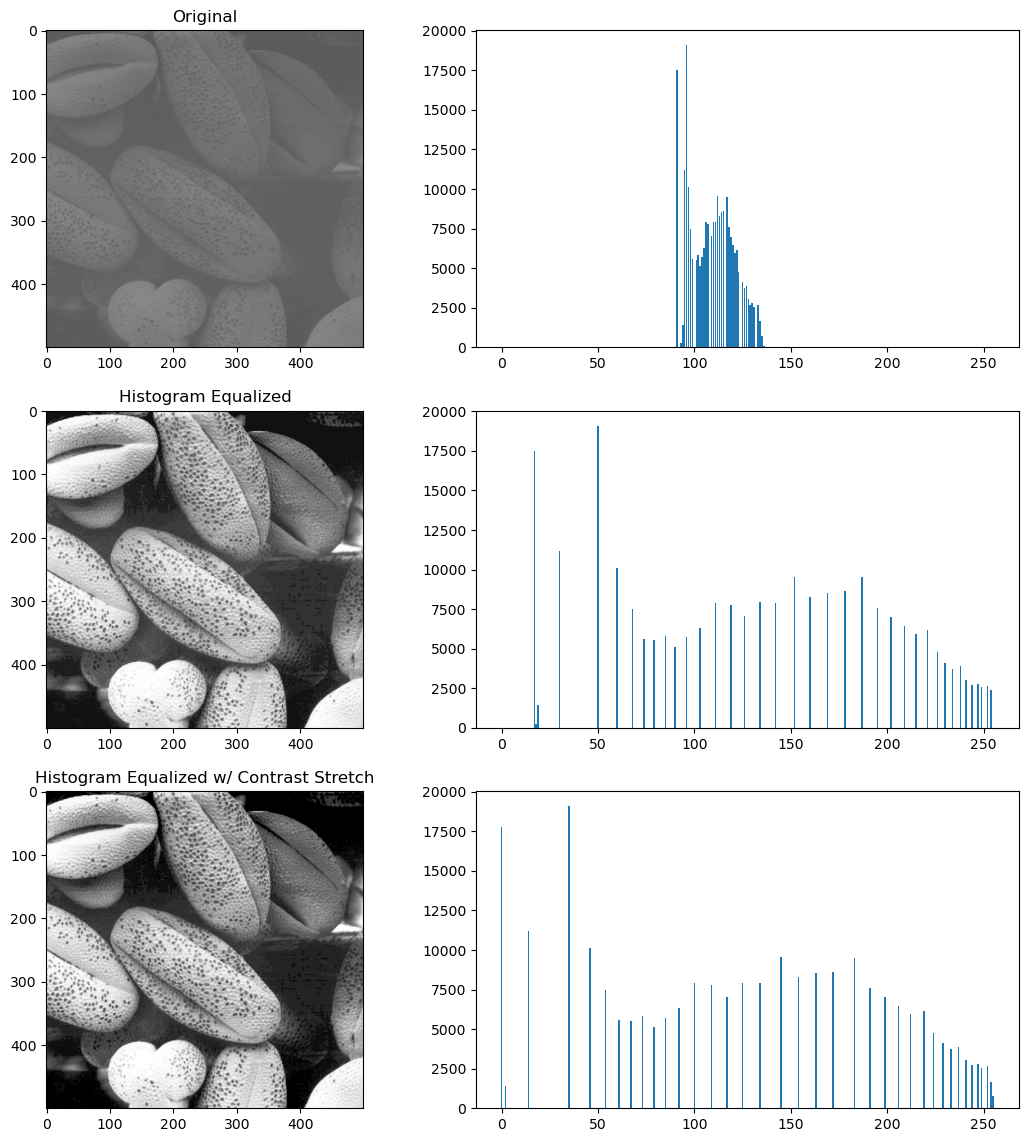

In [61]:
########## GLOBAL HISTOGRAM EQUALIZATION ##########

def hist_eq(imgArr, numLevels=256):
    numPixels = imgArr.shape[0]*imgArr.shape[1]
    cdf = np.zeros(numLevels)
    histogram = histogram_arr(imgArr)
    # Get cumulative distribution function
    for i in range(numLevels):
        sum = 0
        for j in range(i+1):
            sum += histogram[j]
        cdf[i] = sum/numPixels 
    # Apply cdf as transformation function, scaled by number of levels
    outputArr = np.zeros(imgArr.shape, dtype=int)
    for (ind, val) in np.ndenumerate(imgArr):
        outputArr[ind] = (numLevels-1)*cdf[val]
    return outputArr



def hist_eq_stretch(imgArr, numLevels=256):
    numPixels = imgArr.shape[0]*imgArr.shape[1]
    cdf = np.zeros(numLevels)
    histogram = histogram_arr(imgArr)
    # Get cumulative distribution function 
    for i in range(numLevels):
        sum = 0
        for j in range(i+1):
            sum += histogram[j]
        cdf[i] = sum/numPixels 
    # Apply cdf as transformation function and contrast stretch to entire range
    outputArr = np.zeros(imgArr.shape, dtype=int)
    cdfMin = np.amin(cdf[np.nonzero(cdf)])
    for (ind, val) in np.ndenumerate(imgArr):
        outputArr[ind] = round((numLevels-1)*(cdf[val]-cdfMin)/(1-cdfMin))   
    return outputArr


# Apply global histogram equlization to the example image
imgArrHistEq = hist_eq(imgArr)
imgArrHistEqStretch = hist_eq_stretch(imgArr)

# Plot results
bins = np.arange(0,256)
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(14,14))
# Original image and histogram
ax[0,0].imshow(imgArr, cmap="gray",vmin=0,vmax=255)
ax[0,0].set_title("Original")
ax[0,1].bar(bins,histogram_arr(imgArr))
# Histogram equalized image and histogram
ax[1,0].imshow(imgArrHistEq, cmap="gray",vmin=0,vmax=255)
ax[1,0].set_title("Histogram Equalized")
ax[1,1].bar(bins,histogram_arr(imgArrHistEq))
# Histogram equalized with contrast stretch image and histogram
ax[2,0].imshow(imgArrHistEqStretch, cmap="gray",vmin=0,vmax=255)
ax[2,0].set_title("Histogram Equalized w/ Contrast Stretch")
ax[2,1].bar(bins,histogram_arr(imgArrHistEqStretch))
fig.subplots_adjust(wspace=0)

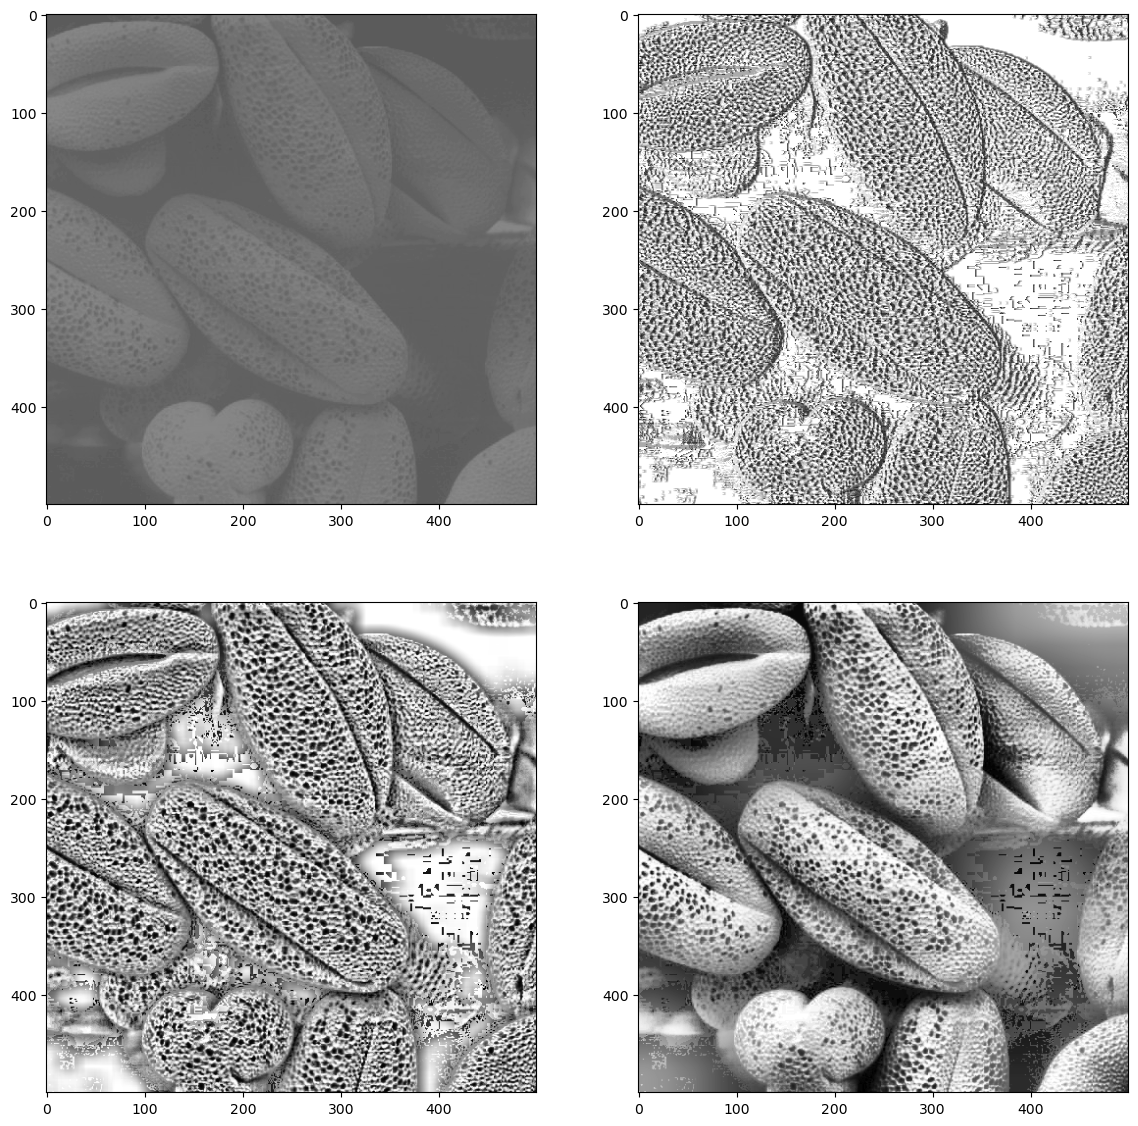

In [40]:
########## ADAPTIVE HISTOGRAM EQUALIZATION ##########

def adaptive_hist_eq(imgArr, kernelSize=3, numLevels=256):
  #padWidth = (kernelSize-1)//2
  padWidth = kernelSize//2
  imgPadArr = mirror_pad(imgArr, padWidth = padWidth)
  outputArr = np.zeros(imgPadArr.shape)
  # Iterate through rows
  for i in range(padWidth,imgPadArr.shape[0]-padWidth):
  # Calculate the histogram at the beginnin of each row
    #histogramDict = {}
    nHood = imgPadArr[i-padWidth:i+padWidth+1,0:2*padWidth+1]
    # Use np iterable instead???
    '''
    for row in nHood:
      for pixel in row:
        if pixel in histogramDict:
          histogramDict[pixel] += 1
        else:
          histogramDict[pixel] = 1
    '''
    histogramDict = histogram_dict(nHood)
    # Iterate through columns
    for j in range(padWidth,imgPadArr.shape[1]-padWidth):
      sum = 0
      for pixel in histogramDict.keys():
        if pixel > imgPadArr[i,j]:
          continue
        pixelProb = histogramDict[pixel]/(kernelSize*kernelSize)
        sum += pixelProb
      outputArr[i,j] = int(numLevels-1)*sum
      # Recalculate histogram as sliding window
      # Remove first column of nhoods values from histogram
      for pixel in nHood[:,0]:
        histogramDict[pixel] -= 1
        # Remove dictionary entry if no entrys
        if histogramDict[pixel] == 0:
          del histogramDict[pixel]
      # Shift nhood over
      if j != imgPadArr.shape[1] - padWidth - 1:
        nHood = imgPadArr[i-padWidth:i+padWidth+1,j-padWidth:j+padWidth+1]
      # Add values from last column of nhood to histogram
      for pixel in nHood[:,-1]:
        if pixel in histogramDict:
          histogramDict[pixel] += 1
        else:
          histogramDict[pixel] = 1

  outputArr = strip_padding(outputArr, padWidth)
  return outputArr

# Apply adaptive histogram equalization with different kernel sizes
imgArrAdHist3 = adaptive_hist_eq(imgArr, kernelSize=3)
imgArrAdHist21 = adaptive_hist_eq(imgArr, kernelSize=21)
imgArrAdHist121 = adaptive_hist_eq(imgArr, kernelSize=141)

# Plot results
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,14))
ax[0,0].imshow(imgArr,cmap="gray",vmin=0,vmax=255)
ax[0,1].imshow(imgArrAdHist3,cmap="gray",vmin=0,vmax=255)
ax[1,0].imshow(imgArrAdHist21,cmap="gray",vmin=0,vmax=255)
ax[1,1].imshow(imgArrAdHist121,cmap="gray",vmin=0,vmax=255)




In [67]:

def adaptive_hist_eq_tiled(imgArr, tileSize=(8,8), numLevels=256):
    # Get necessary padding sizes
    vPad = 0
    hPad = 0
    if imgArr.shape[0] % tileSize[0] != 0:
        vPad = ((imgArr.shape[0]//tileSize[0])*tileSize[0]+tileSize[0])-imgArr.shape[0]
    if imgArr.shape[1] % tileSize[1] != 0:
        hPad = ((imgArr.shape[1]//tileSize[1])*tileSize[1]+tileSize[1])-imgArr.shape[1]
    # Distribute padding as equally as possible on each side
    if vPad % 2 == 0:
        topPad, bottomPad = vPad//2, vPad//2 
    else:
        topPad, bottomPad = vPad//2, vPad//2 + 1
    if hPad % 2 == 0:
        leftPad, rightPad = hPad//2, hPad//2
    else: 
        leftPad, rightPad = hPad//2, hPad//2 + 1
    
    imgPadArr = mirror_pad_axis(imgArr, pad=(topPad,bottomPad,leftPad,rightPad))
    outputArr = np.zeros(imgPadArr.shape)

    for i in range(0, imgPadArr.shape[0], tileSize[0]):
        for j in range(0, imgPadArr.shape[1], tileSize[1]):
            tile = imgPadArr[i:i+tileSize[0],j:j+tileSize[1]] 
            print(tile.shape)
            outputArr[i:i+tileSize[0],j:j+tileSize[1]] = hist_eq(tile)
    return outputArr

print(adaptive_hist_eq_tiled(imgArr, tileSize=(31,33)))

#Error is caused in the histogram_arr function getting called in hist_eq becuase values for some reason are now numpy floats

(31, 33)
<class 'numpy.float64'>


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [53]:
5//2 +1


3